## CAPM Simulation_South Africa

In [1]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [2]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels

In [3]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [4]:
df_MR = pd.read_csv('df_MR.csv')

In [5]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [6]:
df_MR.set_index('Dates',inplace=True)

In [7]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [8]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR.dropna(axis = 0, how = 'all')

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000000,-0.026116,NaN,-0.070618,NaN,NaN,-0.013234,NaN,-0.016129,NaN,...,0.000000,NaN,0.0,NaN,NaN,-0.109199,NaN,NaN,-0.104700,0.000000
2000-01-06,-0.080043,0.000000,NaN,-0.024693,NaN,NaN,0.034932,NaN,-0.033061,NaN,...,0.081967,NaN,0.0,NaN,NaN,-0.039221,NaN,NaN,0.000000,0.000000
2000-01-07,0.117783,-0.005900,NaN,0.048790,NaN,NaN,0.094951,NaN,-0.042925,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,-0.028988,0.000000
2000-01-10,0.068993,0.015656,NaN,0.000000,NaN,NaN,0.043488,NaN,0.074108,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.084557,0.029559
2000-01-11,-0.068993,0.000000,NaN,-0.048790,NaN,NaN,-0.088186,NaN,0.037740,NaN,...,0.081967,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-27,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.080043,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.016737,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [9]:
df_Ex_SR = df_SR-df_RF.values

In [10]:
df_Ex_SR = df_Ex_SR.loc[df_MR.index,:]

In [11]:
ols_model = LinearRegression()

In [12]:
## For each stock, we fit market model regressions to esimate constant betas and residual return standard deviation;
## Then we match the simulation paramters (mean&std_dev) to the distribution of these parametes in the real data.

In [13]:
## Constant beta estimations without rolling windows
all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is cross-sectional stock name
for j in tqdm(df_Ex_SR.columns):
    df_index = df_Ex_SR.loc[:,j].dropna().index

    if len(df_index) != 10:
#         lag = int(4*((len(df_Ex_SR.loc[df_index,j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index,j].values.astype(np.float64), sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 740/740 [00:01<00:00, 374.02it/s]


In [14]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [15]:
## The following is residual return standard deviations
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZPT.SJ.Equity,0.065835
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [16]:
## We conduct simulations with the cross-sectional size of N=819 stocks. We randomly generat daily returns using the following procedures:
## Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [17]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.16514471061904212 0.21161089569068053


In [18]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.01840973708300509 0.013629287305736423


In [19]:
print(m_all_sigmas*252*100, sd_all_sigmas*np.sqrt(252)*100)

463.92537449172823 21.635822854816876


## beta,i and res_sigma,i are fixed through 100 repetitions

In [20]:
# How many stocks in the simulation sample on cross-sectional scale
N = 500

In [21]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.14568705278621497, 0.20443588392284331)

In [22]:
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.141111,0.308424,0.064436,-0.018887,0.137777,0.499618,-0.301275,0.371482,-0.165393,0.240368,...,-0.003257,0.07645,0.457381,-0.051699,0.087789,0.4479,0.107097,0.468321,0.24031,-0.08064


In [23]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.017299003261067925, 0.013772638229073505)

In [24]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.008808,0.001847,0.044761,0.024212,0.01627,0.018673,0.029752,0.01185,0.035452,0.027705,...,0.028433,0.019518,0.013563,0.04063,0.041653,0.028856,0.008606,0.003679,0.0057,0.006584


In [25]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [26]:
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [27]:
print(mean_MKT*252*100, sd_MKT*np.sqrt(252)*100)

7.075328859060404 18.33360968113651


In [28]:
## It's important to make sure that np.mean(sim_MKT_tmp) is precisely equal to mean_MKT, otherwise the gap between 
## ex-ante and ex-post biases will be significant

In [29]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00025055088376690714 0.011764847369875788


In [30]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,-0.011232
2000-01-06,-0.002956
2000-01-07,0.000172
2000-01-10,0.022886
2000-01-11,0.014613
...,...
2019-12-25,-0.015550
2019-12-26,-0.014600
2019-12-27,0.018729


In [31]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [32]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.001928,-0.000548,-0.036971,-0.020747,-0.016812,0.004149,-0.019086,-0.007252,-0.012160,0.022088,...,0.030527,0.003348,-0.010020,0.015178,-0.079374,-0.001303,0.009571,-0.004809,-0.000663,-0.005378
1,0.011369,0.000748,0.060699,0.031456,0.008446,-0.040546,0.001639,0.003108,-0.067634,0.040237,...,-0.021179,-0.024168,-0.010443,-0.027110,0.002116,0.000496,0.007355,0.001246,0.004720,0.001050
2,-0.007504,0.001851,0.021103,0.011250,0.005892,-0.030976,-0.008527,-0.012320,0.045619,0.052015,...,-0.014794,0.021049,0.005672,0.025392,0.035288,0.014813,0.003218,-0.001321,-0.004762,-0.000958
3,-0.004781,0.002040,-0.017861,0.023857,0.018145,-0.001442,-0.033925,-0.010157,-0.040287,0.020708,...,0.042217,-0.015829,0.004990,0.024944,0.054605,-0.038406,0.009432,-0.005199,0.000895,0.006312
4,-0.006233,0.000712,-0.018878,0.015091,0.022889,-0.005300,-0.004622,0.021113,0.055752,0.022222,...,-0.048995,0.000723,0.006309,-0.004491,0.058886,0.017661,-0.009694,0.001802,-0.000894,-0.013087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0.000622,-0.005175,0.024886,0.018018,-0.006783,-0.008100,-0.029266,0.025210,0.025831,0.064280,...,0.011560,-0.006105,-0.006983,0.006589,0.045306,0.024535,0.011288,0.001015,0.001983,-0.003910
5211,0.009694,0.000437,0.128370,0.031034,-0.009874,-0.003160,-0.037912,-0.016884,-0.082827,0.038158,...,-0.006687,0.051573,-0.021362,0.020686,0.084528,0.038534,0.003832,-0.004444,-0.000771,-0.010948
5212,-0.002199,-0.000527,-0.098857,-0.014303,0.016605,0.018581,-0.042936,0.016969,-0.005867,-0.022119,...,0.044550,0.008337,0.009487,0.020892,-0.016326,0.035410,0.014685,0.001110,0.010103,-0.009643
5213,0.014640,0.000276,0.041073,0.011441,-0.020473,0.026846,-0.009271,-0.007303,-0.039497,-0.033188,...,-0.025443,0.012438,0.006989,-0.016036,-0.060887,0.015551,0.006877,0.000154,-0.005338,0.001910


In [33]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [34]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.003513,-0.004012,-0.037695,-0.020535,-0.018360,-0.001463,-0.015702,-0.011424,-0.010303,0.019388,...,0.030563,0.002489,-0.015157,0.015759,-0.080360,-0.006333,0.008368,-0.010069,-0.003362,-0.004473
2000-01-06,0.010952,-0.000164,0.060509,0.031512,0.008039,-0.042023,0.002530,0.002010,-0.067145,0.039527,...,-0.021169,-0.024394,-0.011795,-0.026957,0.001857,-0.000828,0.007038,-0.000138,0.004010,0.001288
2000-01-07,-0.007479,0.001904,0.021114,0.011247,0.005916,-0.030889,-0.008579,-0.012256,0.045590,0.052056,...,-0.014795,0.021062,0.005750,0.025383,0.035304,0.014891,0.003237,-0.001241,-0.004721,-0.000972
2000-01-10,-0.001552,0.009099,-0.016386,0.023425,0.021298,0.009992,-0.040820,-0.001656,-0.044072,0.026209,...,0.042142,-0.014079,0.015457,0.023761,0.056614,-0.028155,0.011883,0.005519,0.006395,0.004466
2000-01-11,-0.004171,0.005219,-0.017936,0.014815,0.024903,0.002001,-0.009025,0.026541,0.053335,0.025735,...,-0.049042,0.001840,0.012993,-0.005247,0.060169,0.024207,-0.008129,0.008646,0.002618,-0.014266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.001573,-0.009971,0.023884,0.018311,-0.008926,-0.015869,-0.024581,0.019433,0.028403,0.060542,...,0.011611,-0.007294,-0.014095,0.007393,0.043941,0.017570,0.009623,-0.006268,-0.001753,-0.002656
2019-12-26,0.007634,-0.004066,0.127429,0.031309,-0.011886,-0.010454,-0.033514,-0.022308,-0.080412,0.034649,...,-0.006639,0.050457,-0.028039,0.021440,0.083246,0.031995,0.002269,-0.011282,-0.004279,-0.009771
2019-12-27,0.000444,0.005249,-0.097650,-0.014657,0.019185,0.027939,-0.048579,0.023927,-0.008965,-0.017617,...,0.044489,0.009769,0.018053,0.019924,-0.014681,0.043799,0.016691,0.009882,0.014604,-0.011154


In [35]:
from datetime import datetime
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [36]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,-0.021877,0.013027,0.102023,0.088423,0.132064,0.119372,0.032180,0.012156,-0.039996,0.108859,...,0.016736,0.066605,-0.004055,0.226051,0.218760,0.078710,0.059399,0.027671,0.019753,-0.036100
2000-02,-0.033443,-0.033060,-0.080907,0.025254,-0.149139,0.029176,0.028957,-0.018264,0.151242,0.175619,...,0.286456,0.091151,0.109439,-0.174351,-0.085905,0.015292,0.054719,-0.014838,-0.029429,-0.012078
2000-03,0.008701,-0.001807,-0.070930,0.039503,0.114397,-0.072458,0.011722,-0.030708,-0.233630,-0.112576,...,0.028956,0.128392,-0.026144,-0.113770,-0.116837,0.003469,0.054427,0.007420,0.004937,0.025127
2000-04,0.003897,0.010968,-0.137832,-0.074627,0.022495,0.017160,0.236791,-0.084188,-0.228178,0.070056,...,0.092014,0.049421,0.054227,-0.197754,0.125617,0.019342,0.047139,0.030819,0.007253,-0.029453
2000-05,-0.029601,-0.013796,0.289706,-0.068900,0.018986,-0.237215,0.210687,-0.106427,0.029886,0.036734,...,0.081397,-0.085592,-0.012905,0.068487,-0.130737,-0.002057,0.000335,-0.031855,-0.052122,-0.018969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.005013,0.002803,-0.051890,0.086501,0.051484,-0.039576,-0.033907,0.061569,-0.098521,0.028103,...,0.037524,0.020130,0.051196,0.042853,-0.138663,0.004340,-0.126285,-0.043031,0.047033,0.029264
2020-05,-0.008189,-0.002476,-0.118975,0.056203,0.027386,0.080286,0.169011,-0.049323,0.175144,-0.196566,...,0.144134,0.098801,-0.012563,-0.393660,0.464727,-0.159112,0.037395,-0.011097,0.027863,0.010631
2020-06,0.031718,0.049333,-0.377826,0.119237,-0.011869,-0.014273,-0.012212,0.062242,0.057281,0.083190,...,-0.053998,-0.128330,-0.049798,0.180735,0.131800,0.172370,-0.008597,0.060215,0.017773,-0.021301


In [37]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.050896
2000-02,-0.050989
2000-03,0.000958
2000-04,0.071943
2000-05,-0.043425
...,...
2020-04,-0.026179
2020-05,-0.020651
2020-06,0.109066


In [38]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [39]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0177
No. Factors:                          1   J-statistic:                    610.40
No. Observations:                  5215   P-value                         0.0005
Date:                  Wed, Apr 20 2022   Distribution:                chi2(499)
Time:                          12:44:20                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0002     0.0002     0.9164     0.3595     -0.0002      0.0005
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [40]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-sim_MKT.mean())/sim_MKT.mean()*100).values))

ex-ante bias(%):[-43.93960692]
ex-post bias(%):[-37.17879112]


In [41]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

In [42]:
all_betas_test = pd.DataFrame()
all_resids = pd.DataFrame()

# i is time in periods
for j in tqdm(sim_SR.columns):
    
    betas = []
    # j is cross-sectional stock name
#     lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
    ols = sm.OLS(sim_SR.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT.values.astype(np.float64)))
    res = ols.fit()
#     res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
    b = list(res.params)
    r = list(res.resid)
    betas.append(b)
    
    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept', 1:'MKT'})
    all_betas_test = pd.concat([all_betas_test, df_betas], axis = 0)
    all_resids = pd.concat([all_resids, pd.DataFrame(r)], axis = 1)

100%|██████████| 500/500 [00:02<00:00, 230.63it/s]


In [43]:
all_betas_test = all_betas_test.reset_index(drop=True)
all_betas_test 

,Intercept,MKT
0,0.000180,0.123808
1,0.000006,0.307443
2,-0.000735,0.020023
3,0.000190,0.056136
4,0.000050,0.130436
...,...,...
495,-0.000227,0.439732
496,0.000114,0.105435
497,0.000014,0.472258
498,0.000057,0.249799


In [44]:
all_resids.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.002302,-0.000565,-0.036735,-0.020094,-0.016944,0.003905,-0.019490,-0.007470,-0.011224,0.022802,...,0.030991,0.002837,-0.010127,0.014849,-0.080005,-0.001167,0.009439,-0.004779,-0.000613,-0.005300
1,0.011138,0.000739,0.061303,0.031488,0.008375,-0.040894,0.000946,0.002928,-0.067146,0.040787,...,-0.020619,-0.024526,-0.010432,-0.027548,0.001587,0.000699,0.007237,0.001244,0.004691,0.001031
2,-0.007680,0.001846,0.021845,0.011047,0.005843,-0.031363,-0.009330,-0.012486,0.045937,0.052503,...,-0.014199,0.020748,0.005727,0.024913,0.034798,0.015042,0.003105,-0.001336,-0.004821,-0.001014
3,-0.004565,0.002057,-0.016109,0.021950,0.018263,-0.002118,-0.035521,-0.010222,-0.041201,0.020745,...,0.043074,-0.015710,0.005371,0.024167,0.054395,-0.037992,0.009357,-0.005303,0.000621,0.005991
4,-0.006160,0.000721,-0.017494,0.013805,0.022947,-0.005870,-0.005929,0.021011,0.055286,0.022424,...,-0.048233,0.000690,0.006572,-0.005160,0.058574,0.018008,-0.009783,0.001731,-0.001090,-0.013312


In [45]:
corr_x_res = []

for j in tqdm(range(len(all_resids.columns))):
    corr = stats.pearsonr(sim_MKT.values.flatten(), all_resids.iloc[:,j].values)
    corr_x_res.append(corr)

100%|██████████| 500/500 [00:00<00:00, 6589.10it/s]


In [46]:
pd.DataFrame(corr_x_res).head()

,0,1
0,-8.543513e-17,1.0
1,-1.634977e-15,1.0
2,9.540979e-18,1.0
3,1.734723e-17,1.0
4,-9.909608e-17,1.0


In [47]:
from statsmodels.graphics.tsaplots import plot_acf

Asset_Number = 418


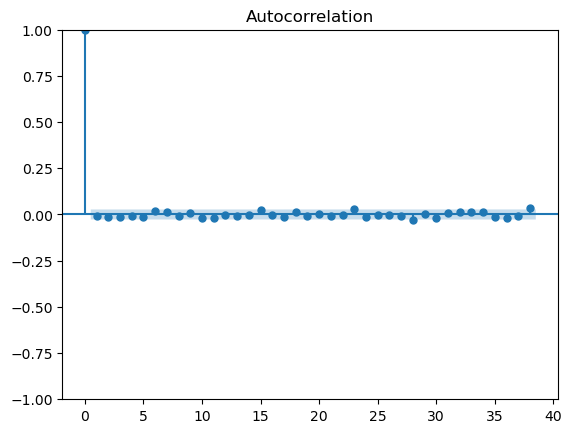

In [48]:
k = np.random.randint(0,len(sim_SR.columns))
plot_acf(all_resids.iloc[:,k])
print('Asset_Number = ' + str(k))
plt.show()

In [49]:
from statsmodels.stats.stattools import durbin_watson

In [50]:
## The null hypothesis of the test is that there is no serial correlation in the residuals. AR(1)
## the value of dw test is very close to 2*(1-rho_hat)
all_dws = []

for j in range(len(all_resids.columns)):
    dw = durbin_watson(all_resids.iloc[:,j])
    all_dws.append(dw)

print(np.mean(all_dws))

2.0020361638342807


In [51]:
beta_err = sim_betas - all_betas_test.MKT

In [52]:
durbin_watson(beta_err.T)

array([2.02253499])

In [53]:
lamdas = []

for i in tqdm(range(len(sim_SR))):
    ols = sm.OLS(sim_SR.iloc[i,:], sim_betas.T)
    res = ols.fit()
    l = list(res.params)
    lamdas.append(l)

100%|██████████| 5215/5215 [00:07<00:00, 682.23it/s]


In [54]:
print(np.mean(lamdas), mean_MKT)

0.0001548144261827043 0.0002807670182166827


In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

In [56]:
## The null hypothesis of the test is that there is no serial correlation in the residuals. AR(n)
all_lbs = []

for j in range(len(all_resids.columns)):
    lb = lb_test(all_resids.iloc[:,j], lags=None, boxpierce=False)
    all_lbs.append(lb)

print(np.mean(all_lbs))

2.9852073563112844


In [57]:
lb_test(all_resids.iloc[:,j])

,lb_stat,lb_pvalue
1,0.001171,0.972703
2,1.160711,0.559699
3,2.089829,0.553973
4,7.511188,0.111217
5,7.572509,0.181423
6,12.248723,0.056645
7,13.594423,0.058883
8,13.820756,0.086559
9,14.174459,0.116253
10,14.501597,0.151317


Asset_Number = 397


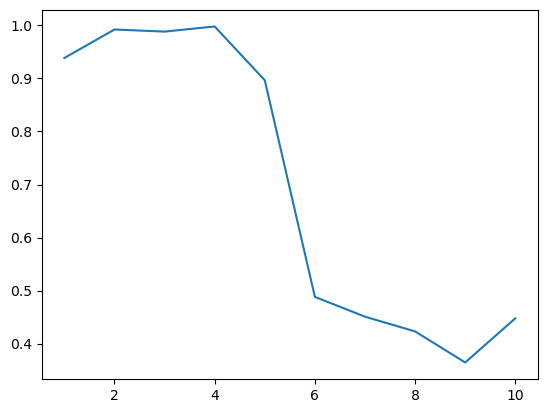

In [58]:
h = np.random.randint(0,len(all_resids.columns))
plt.plot(lb_test(all_resids.iloc[:,h]).iloc[:,1])
print('Asset_Number = ' + str(h))
plt.show()

## OLS (Time-varying Betas)

In [119]:
# how many years in the rolling window periods
n = 5

In [120]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 1260


In [121]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 187/187 [01:14<00:00,  2.52it/s]


In [122]:
all_betas[0]

,Intercepts,MKT
0,-0.000107,0.127468
1,-0.000076,0.304612
2,-0.002393,0.092917
3,0.000498,0.213229
4,-0.000206,0.130538
...,...,...
495,0.000004,0.404213
496,0.000367,0.089175
497,-0.000192,0.478718
498,-0.000018,0.271627


In [123]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9687532640973985 4030.037972564292


In [124]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [125]:
# sum daily market return to compute corresponding monthly returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


In [126]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 530.24it/s]


In [127]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.012286,-0.016176
1,0.000173,-0.070791
2,0.006577,-0.024486
3,-0.000761,-0.042157
4,-0.005881,-0.081098
...,...,...
182,0.000390,-0.033156
183,0.000452,-0.059312
184,-0.001930,-0.049726
185,0.001617,0.099807


In [128]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.012817,-0.010001,0.087617,0.027334,0.004926,0.005276,0.066717,0.031568,0.020926,0.021766,...,0.089963,-0.014037,-0.008574,0.013952,0.014563,-0.006997,0.012850,0.000506,0.016309,-0.055497
1,0.011211,-0.011245,0.003524,0.007265,0.001110,0.025983,0.018312,0.004695,-0.012318,-0.015012,...,0.011051,-0.010126,-0.001731,0.012166,0.009258,-0.007721,0.020491,0.014715,0.016943,0.003172
2,0.074349,-0.054566,0.086473,-0.389133,-0.010031,0.187670,0.193075,0.141163,-0.187677,-0.075275,...,-0.019394,-0.018164,0.152680,0.070575,0.271026,0.081722,-0.054979,-0.119807,-0.375483,-0.323514
3,-0.018139,0.040095,-0.086408,-0.120192,0.065257,0.034244,-0.180641,0.004710,0.135903,0.083380,...,-0.207352,-0.070209,-0.142535,0.228127,0.184081,-0.059136,0.082744,0.054833,0.123255,0.008837
4,-0.025401,0.096405,-0.028880,-0.065677,-0.026744,-0.004825,-0.129427,0.138693,-0.044595,-0.057011,...,-0.041766,-0.078032,0.046334,-0.091160,-0.079184,0.017326,0.057742,0.035327,-0.026640,-0.022683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.157779,-0.025121,-0.269403,-0.244760,-0.232278,0.241134,0.092856,0.267160,0.011141,0.190503,...,0.127688,-0.188331,-0.073721,0.119835,0.195339,-0.142640,0.029784,-0.135160,0.125287,0.108992
496,-0.008084,0.010594,-0.008310,-0.009228,0.038971,-0.010023,0.021539,-0.069165,-0.093919,0.035612,...,0.043595,-0.073569,0.075634,0.007759,-0.039742,0.024612,-0.120136,0.044864,-0.021152,0.003423
497,0.032613,-0.009859,0.016454,-0.004617,0.022951,0.017898,-0.016607,-0.027612,0.015823,-0.006410,...,0.037501,0.003851,0.002085,0.000400,-0.014499,-0.010066,-0.016055,0.013841,0.012402,0.002250
498,0.038004,-0.010832,0.041880,-0.012215,-0.027170,-0.039729,0.017069,0.001717,0.007589,0.029086,...,0.003487,-0.015909,0.005800,0.027863,-0.059108,0.009404,0.061781,0.042529,-0.009845,-0.080191


In [129]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([ 1.39702694, -0.18305171]), pvalue=array([0.16406993, 0.85495683]))

In [130]:
## ***Risk Premium estimate for one simulation
all_lambdas_OLS[0].iloc[:,1].mean() # simulation market premium
## ***Corresponding true simulation parameters, 0.0002807670182166827 is our true daily market risk premium, i.e. 0.07075328859060404 per annum
np.mean(m_MR) #true market premium
print(m_MR.values.mean(), all_lambdas_OLS[0].iloc[:,1].mean())

0.00593024193548387 -0.0007258761364729736


/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [131]:
# Test whether the betas in FM-2 is endougenous

In [132]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

5.039510846654548e-18 x is Exogenous


In [133]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [134]:
print(np.mean(m_MR.values),np.mean(all_lambdas_OLS[0].iloc[:,1].values))

0.00593024193548387 -0.0007258761364729743


In [135]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -112.2402449068673
ex-post bias(%): -113.52599734569687


In [136]:
## The Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07553718210104135

In [137]:
## The Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07615242921236424

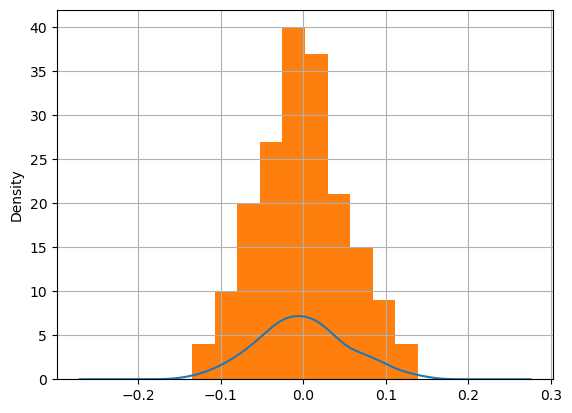

In [138]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [139]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

1260 187


In [140]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 187/187 [02:54<00:00,  1.07it/s]


In [141]:
all_betas_ev[0]

,0
0,0.138297
1,0.298791
2,-0.029220
3,0.241512
4,0.181205
...,...
495,0.371166
496,0.068132
497,0.461296
498,0.263833


In [142]:
all_betas_iv[0]

,0
0,0.118199
1,0.310060
2,0.209347
3,0.185426
4,0.076829
...,...
495,0.434988
496,0.110419
497,0.496737
498,0.280811


### Correlation between ev_errors and iv_errors

In [143]:
h = np.random.randint(0,periods)
print(h)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
np.cov(beta_err_ev.flatten(), beta_err_iv.flatten())[0,1]

137


0.0006959807897668866

In [144]:
h = np.random.randint(0,periods)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())

(0.06297955238760464, 0.1596834275489298)

In [145]:
corr_errs = []
for i in range(periods):
    beta_err_ev = all_betas_ev[i].values - sim_betas.T.values
    beta_err_iv = all_betas_iv[i].values - sim_betas.T.values
    corr = stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())
    corr_errs.append(corr)
print(pd.DataFrame(corr_errs).mean())

0   -0.009172
1    0.368216
dtype: float64


In [146]:
pd.DataFrame(corr_errs).describe()

,0,1
count,187.000000,187.000000
mean,-0.009172,0.368216
std,0.068649,0.321544
min,-0.151193,0.000377
25%,-0.056288,0.066933
50%,-0.012258,0.267670
75%,0.029994,0.614360
max,0.158416,0.983090


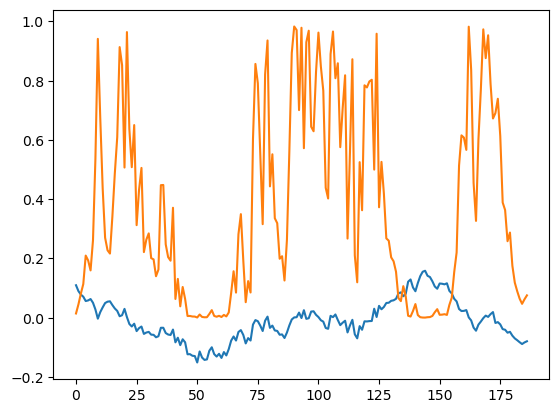

In [147]:
plt.plot(corr_errs)
plt.show()

In [148]:
## Calculating the estimated lambdas

In [149]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [150]:
# A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)
# should have an F statistic of at least 10.

fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 187/187 [00:00<00:00, 1046.95it/s]


In [151]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1568.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):          5.45e-156
Time:                        12:55:11   Log-Likelihood:                 395.06
No. Observations:                 500   AIC:                            -786.1
Df Residuals:                     498   BIC:                            -777.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.006      1.548      0.122      -0.002       0.021
x1             0.9109      0.023     39.603      0.000       0.866       0.956
==============================================================================
Omnibus:                       31.220   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.025
Skew:                          -0.223   Prob(JB):                     2.83e-20
Kurtosis:                       5.030   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
pd.DataFrame(fvalues).describe()

,0
count,187.000000
mean,1767.084333
std,158.905873
min,1448.426504
25%,1625.029294
50%,1763.009091
75%,1874.267242
max,2264.399250


In [153]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:01<00:00, 165.20it/s]


In [154]:
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                      0.0215
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0195
No. Observations:                 500   F-statistic:                    15.025
Date:                Wed, Apr 20 2022   P-value (F-stat)                0.0001
Time:                        12:55:12   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog          -0.0034     0.0064    -0.5340     0.5933     -0.0159      0.0091
endog          0.1005     0.0259     3.8762     0.0001      0.0497      0.1513
==============================================================================

Endogenous: endog
Instruments: instruments
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [155]:
res.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 6.5802
P-value: 0.0106
Distributed: F(1,497)
WaldTestStatistic, id: 0x7feae98e1b50

In [156]:
# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [157]:
# Use the IV estimator equation to calculate lambdas

In [158]:
lam = []
for i in range(periods):
    a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
    b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
    l = np.linalg.inv(a)*b
    lam.append(l)

In [159]:
print(np.mean(lam),stats.ttest_1samp(lam, 0.0)[0])

0.0006948104209640838 [[0.16841066]]


In [160]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.012979,-0.009723,0.087854,0.027714,0.005449,0.005666,0.066432,0.031965,0.020075,0.022801,...,0.084097,-0.014638,-0.005565,0.011542,0.015737,-0.005657,0.016344,0.003115,0.010456,-0.060382
1,0.010800,-0.009351,0.002952,0.007042,0.001740,0.026897,0.016365,0.003882,-0.010983,-0.013808,...,0.010335,-0.011263,0.000738,0.014045,0.008973,-0.009024,0.022616,0.014470,0.015515,0.001489
2,0.072678,-0.066030,0.084151,-0.393523,-0.017514,0.181691,0.197420,0.139940,-0.185803,-0.080996,...,-0.055119,-0.022707,0.167631,0.052560,0.277414,0.088199,-0.043483,-0.109616,-0.397909,-0.343255
3,-0.017890,0.042132,-0.086514,-0.119853,0.067588,0.035117,-0.181784,0.004765,0.135043,0.084365,...,-0.199548,-0.068076,-0.146849,0.227433,0.183358,-0.058064,0.079160,0.055085,0.123876,0.009448
4,-0.024676,0.099168,-0.027955,-0.064455,-0.025322,-0.003406,-0.130130,0.139516,-0.045959,-0.054928,...,-0.043709,-0.078271,0.046458,-0.092247,-0.079071,0.017388,0.056995,0.034818,-0.026674,-0.023429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.158768,-0.021994,-0.270352,-0.245045,-0.232517,0.240844,0.090749,0.264790,0.015485,0.189307,...,0.123018,-0.190749,-0.069638,0.122836,0.195401,-0.144874,0.033396,-0.136018,0.122166,0.106648
496,-0.008304,0.008429,-0.008735,-0.010388,0.036364,-0.011551,0.022781,-0.069486,-0.093724,0.034118,...,0.041294,-0.073590,0.075855,0.006776,-0.039427,0.025140,-0.120168,0.045230,-0.021249,0.003308
497,0.031705,-0.006173,0.015216,-0.005295,0.023895,0.019488,-0.020363,-0.029406,0.018747,-0.004240,...,0.035215,0.001445,0.007312,0.003790,-0.014953,-0.012505,-0.011053,0.013941,0.008630,-0.001686
498,0.037627,-0.009874,0.041370,-0.012605,-0.027465,-0.039753,0.016074,0.000739,0.009101,0.029057,...,0.001005,-0.016930,0.008574,0.027987,-0.058726,0.008990,0.064516,0.043259,-0.013229,-0.083240


In [161]:
# # Plot the distrubtion of the residuals
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [162]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

4.525819336054464e-18 IV is Exogenous


In [163]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.000813882740825682 EV is Endogenous


In [164]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [165]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.8826131690595155 IV is Strong


In [166]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [167]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9442348424796632 4403.028912049931


In [168]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.012037,-0.014279
1,0.002304,-0.085596
2,0.006203,-0.021772
3,-0.000706,-0.042296
4,-0.004780,-0.088080
...,...,...
182,-0.000834,-0.025485
183,0.002529,-0.074974
184,-0.002083,-0.049873
185,0.000244,0.111452


In [169]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([ 1.33207505, -0.14018325]), pvalue=array([0.18446541, 0.88866689]))

In [170]:
all_lambdas_IV[0].describe()

,0,1
count,187.000000,187.000000
mean,0.000564,-0.000599
std,0.005785,0.058394
min,-0.015220,-0.137697
25%,-0.003385,-0.039761
50%,0.000810,0.000578
75%,0.004278,0.034129
max,0.017863,0.146828


In [171]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -110.09424882902945
ex-post bias(%): -111.15457933293918


In [172]:
# ## The Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07834435603715435

In [173]:
## The Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.0791432148268299

## OLS with beta_ev

In [114]:
from linearmodels.iv.model import IV2SLS

all_lambdas_ols = []
all_resids_ols = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    ols = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = pd.concat([pd.DataFrame(np.ones(len(m_sim_SR.T), dtype=np.uint8)).T, all_betas_ev[i].T], axis =0,ignore_index=True).T,\
                endog = None,\
                instruments = None)
    res = ols.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_ols.append(pd.DataFrame(lambdas))
all_resids_ols.append(pd.DataFrame(resids))

100%|██████████| 223/223 [00:01<00:00, 137.24it/s]


In [115]:
all_resids_ols = pd.DataFrame(all_resids_ols[0].T)
all_resids_ols

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,-0.007188,-0.003466,0.032349,0.046340,-0.051349,-0.018349,-0.046264,0.040773,-0.006100,-0.061904,...,0.081293,-0.014050,-0.005852,0.010224,0.015647,-0.004204,0.014715,0.004980,0.007273,-0.062210
1,0.015011,0.010871,-0.017619,-0.003727,-0.001319,-0.010019,0.040532,0.002480,0.000851,-0.015864,...,0.014351,-0.006880,-0.005877,0.015985,0.006868,-0.008000,0.013917,0.014653,0.020355,0.007485
2,-0.202705,0.099071,0.030319,0.380389,0.295287,0.229248,0.191008,0.129529,0.114660,-0.056718,...,-0.035819,-0.021038,0.158806,0.064785,0.273427,0.078228,-0.048058,-0.122274,-0.368683,-0.320230
3,0.089078,-0.005315,-0.046863,-0.170356,0.058466,0.032337,-0.293051,0.257810,0.035287,0.116075,...,-0.214333,-0.074243,-0.134257,0.218874,0.189251,-0.053080,0.094604,0.064885,0.105331,-0.007603
4,0.063980,0.121007,-0.025892,0.059801,-0.101969,0.157037,-0.077881,-0.142445,-0.123191,0.007828,...,-0.047296,-0.078435,0.049146,-0.094676,-0.077758,0.018583,0.059580,0.036048,-0.031284,-0.027198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.108530,-0.229364,0.201633,-0.086211,0.066291,0.014512,-0.031211,-0.009292,0.130851,-0.125395,...,0.120127,-0.181475,-0.083363,0.130003,0.191759,-0.141712,0.017465,-0.136342,0.135060,0.120991
496,0.022430,-0.013495,0.055092,0.033362,-0.017026,0.083328,0.069094,-0.064999,0.038786,0.042313,...,0.030103,-0.073485,0.078923,0.002972,-0.038323,0.026956,-0.117922,0.046805,-0.021405,0.002695
497,0.009251,-0.000550,-0.026719,-0.002981,0.014373,-0.016563,0.024349,0.007353,-0.008904,0.012171,...,0.043484,0.010326,-0.006243,0.008219,-0.019445,-0.011232,-0.029320,0.013317,0.019205,0.011048
498,0.016294,0.040238,-0.049570,-0.000589,0.017772,-0.000116,-0.012521,0.035092,-0.033002,-0.038179,...,-0.001246,-0.013344,0.004722,0.027337,-0.059836,0.011336,0.058180,0.045085,-0.011965,-0.080369


In [116]:
all_lambdas_ols[0].rename(columns = {0:'Intercepts', 1:'MKT'})

,Intercepts,MKT
0,-0.003843,-0.111906
1,0.001034,-0.013898
2,0.002426,0.012616
3,0.004243,0.038401
4,0.007283,0.044487
...,...,...
218,0.000210,-0.031734
219,-0.005761,-0.017558
220,-0.002111,-0.049259
221,0.004966,0.079012


In [117]:
corr_betas_ev_res = []

for i in range(np.shape(all_resids_ols)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_ols.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_ev_res.append(corr)
    
# expression_if_true if condition else expression_if_false
print(np.mean(corr_betas_ev_res), "EV is Endogenous" if np.mean(corr_betas_ev_res).round(10)!=0 else "EV is Exogenous")


-4.060653159012975e-18 EV is Exogenous


In [118]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_MR_tmp.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_sim_MKT_tmp.values))/np.mean(m_sim_MKT.values)*100))   
## The result is almost the same as the OLS section

ex-ante bias(%): -91.88497063041093
ex-post bias(%): -84.59701881812596
